In [12]:
import os
import shutil
import cv2
from imutils import face_utils
import numpy as np
import pandas as pd
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
import torchvision.models as models

import warnings
warnings.filterwarnings("ignore")


# Load the pre-trained Haar Cascade face detector globally
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [2]:
def move_folders_with_low_count(source_folder, destination_folder, max_file_count):
    try:
        # Create the destination folder if it doesn't exist
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)

        # Iterate through subfolders
        for subfolder_name in os.listdir(source_folder):
            subfolder_path = os.path.join(source_folder, subfolder_name)
#             print(subfolder_path)
            # Check if it's a directory
            if os.path.isdir(subfolder_path):
                # Get the list of files in the subfolder
                files = os.listdir(subfolder_path)

                # Filter out files with common image extensions
                image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]

                # Count the number of images
                num_images = len(image_files)
                #print(num_images<max_file_count)
                if num_images > max_file_count:
#                     print(num_images)
                    print(f"Copying subfolder: {subfolder_name}, Number of images: {num_images}")
                    destination_path = os.path.join(destination_folder, subfolder_name)
                    shutil.copytree(subfolder_path, destination_path)

    except FileNotFoundError:
        print(f"The folder '{source_folder}' does not exist.")



In [3]:
root_path = "C:/Users/WKno1/Data/"

In [4]:
source_folder = root_path+"celebrities_images/"
destination_folder = root_path+"Reduced_Count/"
max_file_count = 205
move_folders_with_low_count(source_folder, destination_folder, max_file_count)

Copying subfolder: Aishwarya Rai, Number of images: 218
Copying subfolder: Anushka Sharma, Number of images: 209
Copying subfolder: Deepika Padukone, Number of images: 227
Copying subfolder: Katrina Kaif, Number of images: 206
Copying subfolder: Kriti Sanon, Number of images: 212
Copying subfolder: Prabhas, Number of images: 245


In [5]:
SOURCE_PATH = root_path+"Reduced_Count/"
DEST_PATH = root_path+"processed_dataset/"
SCALED_PATH = root_path+"SCALED_dataset/"

In [6]:
def detect_faces(image_path):
    # Read the image and convert it to grayscale
    image = cv2.imread(str(image_path))

    # Check if the image is successfully loaded
    if image is None:
        print(f"Error loading image: {image_path}")
        return [], None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

    return faces, gray

# Function to align faces
def align_faces(image, face):
    (x, y, w, h) = face

    if w > 0 and h > 0:
        aligned_face = image[y:y + h, x:x + w]
        aligned_face = cv2.resize(aligned_face, (224, 224))
    else:
        aligned_face = image

    return aligned_face

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

splitfolders.ratio(SOURCE_PATH, output=DEST_PATH, seed=1337, ratio=(.8, .1, .1), group_prefix=None)


Copying files: 1318 files [00:07, 177.05 files/s]


In [7]:
# Specify the path where you want to create the folder
folder_path = Path(SCALED_PATH)
test_folder=Path(SCALED_PATH + "test")
train_folder=Path(SCALED_PATH + "train")
val_folder=Path(SCALED_PATH + "val")

folder_path.mkdir(parents=True, exist_ok=True)
test_folder.mkdir(parents=True, exist_ok=True)
train_folder.mkdir(parents=True, exist_ok=True)
val_folder.mkdir(parents=True, exist_ok=True)

In [8]:
folder_path = Path(SCALED_PATH)
for set_name in ['train', 'val', 'test']:
    set_path = Path(DEST_PATH) / set_name
    #print(set_path)

    # Iterate through classes in each set
    for class_name in set_path.iterdir():
        if not class_name.is_dir():
            continue
        for img_path in class_name.iterdir():
            if not img_path.is_file():
                continue

            
            faces, gray = detect_faces(img_path)

           
            if gray is not None:
               
                for i, face in enumerate(faces):
                    aligned_face = align_faces(gray, face)
                    #print(class_name.stem)

                    # Save the aligned face
                    output_path_aligned = folder_path/set_name/ f"{class_name.stem}_{img_path.stem}_{i}.jpg"
                    cv2.imwrite(str(output_path_aligned), aligned_face)

Error loading image: C:\Users\WKno1\Data\processed_dataset\train\Anushka Sharma\29.gif
Error loading image: C:\Users\WKno1\Data\processed_dataset\train\Anushka Sharma\34


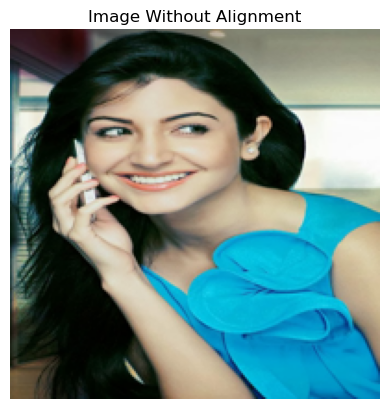

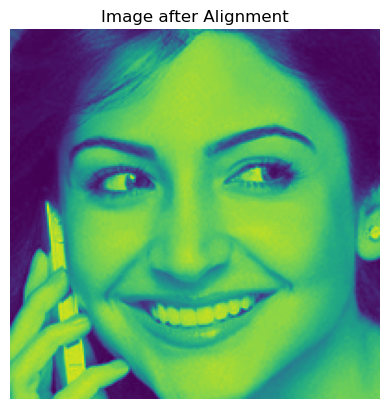

In [37]:
from IPython.display import display, Image,HTML
from PIL import Image as Image
from pathlib import Path
def display_image(img_path,label):
    img = Image.open(img_path)
    img_resized = img.resize((200, 200))
#   Display the resized image with a label using plt
    plt.imshow(img_resized)
    plt.title(label)
    plt.axis('off')  # Optionally, turn off axis labels
    plt.show()
display_image(root_path+'processed_dataset/train/Anushka Sharma/39.jpg',"Image Without Alignment")
display_image(root_path+"SCALED_dataset/train/Anushka Sharma_39_0.jpg", "Image after Alignment")

In [17]:

# Define the path to your dataset
data_dir = SCALED_PATH

# Create a list to store file paths and labels
file_paths = []
labels = []

# Iterate through the folders (training, validation, testing)
for split in ["train", "val", "test"]:
    split_path = Path(data_dir) / split
    
    # Iterate through the subfolders (person names)
    for person_name in os.listdir(split_path):
        file_path = Path(split_path) / person_name 
        #print(file_path)
        # Iterate through the image files
        
        file_paths.append(file_path)
        labels.append(person_name.split("_")[0])

# Create a DataFrame
data = pd.DataFrame({"file_path": file_paths, "label": labels})

# Display the first few rows of the DataFrame
data.head()


,file_path,label
0,C:\Users\WKno1\Data\SCALED_dataset\train\Aishw...,Aishwarya Rai
1,C:\Users\WKno1\Data\SCALED_dataset\train\Aishw...,Aishwarya Rai
2,C:\Users\WKno1\Data\SCALED_dataset\train\Aishw...,Aishwarya Rai
3,C:\Users\WKno1\Data\SCALED_dataset\train\Aishw...,Aishwarya Rai
4,C:\Users\WKno1\Data\SCALED_dataset\train\Aishw...,Aishwarya Rai


In [18]:
data["label"].value_counts()

label
Prabhas             209
Aishwarya Rai       207
Kriti Sanon         205
Anushka Sharma      203
Katrina Kaif        202
Deepika Padukone    190
Name: count, dtype: int64

In [19]:
data.shape

(1216, 2)

In [20]:
num_labels = data['label'].nunique()
num_labels

6

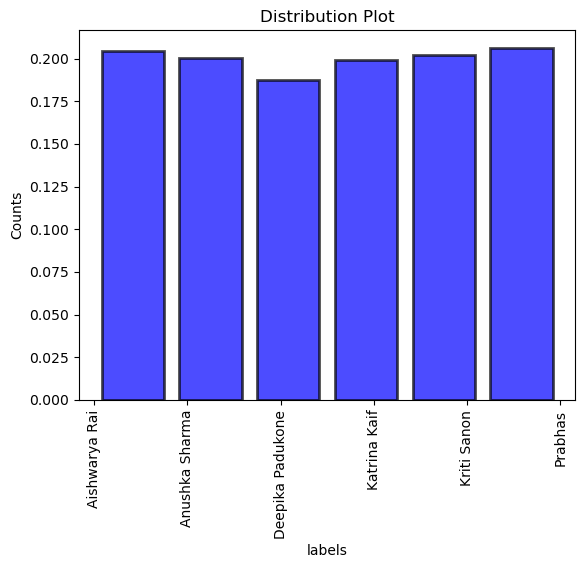

In [21]:
import matplotlib.pyplot  as plt

plt.hist(data['label'], bins=num_labels, density=True, alpha=0.7, color='blue', edgecolor='black',rwidth=0.8,linewidth=2)
xtick_labels = plt.xticks()[0]
plt.xticks(xtick_labels, rotation=90)

# Add labels and title
plt.xlabel('labels')
plt.ylabel('Counts')
plt.title('Distribution Plot')

# Show the plot
plt.show()

In [22]:
label_encoder = LabelEncoder()

data['label_encode'] = label_encoder.fit_transform(data['label'])


In [23]:
data= data.drop(columns = ['label'])
data.head()

,file_path,label_encode
0,C:\Users\WKno1\Data\SCALED_dataset\train\Aishw...,0
1,C:\Users\WKno1\Data\SCALED_dataset\train\Aishw...,0
2,C:\Users\WKno1\Data\SCALED_dataset\train\Aishw...,0
3,C:\Users\WKno1\Data\SCALED_dataset\train\Aishw...,0
4,C:\Users\WKno1\Data\SCALED_dataset\train\Aishw...,0


In [24]:
# SimCLR Encoder 
class Encoder(nn.Module):
    def __init__(self, base_encoder, out_dim):
        super(Encoder, self).__init__()
        self.base_encoder = nn.Sequential(*list(base_encoder.children())[:-1])
        self.projection_head = nn.Sequential(
            nn.Linear(base_encoder.fc.in_features, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        x = self.base_encoder(x)
        x = x.view(x.size(0), -1)
        x = self.projection_head(x)
        return x


In [25]:
# Contrastive Loss Function (InfoNCE)
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, z1, z2):
        # Cosine similarity
        similarities = torch.matmul(z1, z2.T) / self.temperature
        # Diagonal elements are positives, off-diagonal elements are negatives
        labels = torch.arange(similarities.size(0)).to(similarities.device)
        loss = self.criterion(similarities, labels)
        return loss

In [26]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
print(device)

cpu


In [28]:
# Split data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data["label_encode"])



In [29]:
# DataLoader for training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [30]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Assuming the image paths are in the first column
        label = self.dataframe.iloc[idx,1]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [32]:
train_dataset = CustomDataset(train_data, transform=transform)
val_dataset = CustomDataset(val_data, transform=transform)

In [33]:

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)


In [34]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [38]:

# Load a pre-trained ResNet18 model for SimCLR
resnet_encoder = models.resnet18(pretrained=True)
simclr_encoder = Encoder(resnet_encoder, out_dim=num_labels).to(device)



# Loss and optimizer
contrastive_loss = ContrastiveLoss()
optimizer = optim.Adam(simclr_encoder.parameters(), lr=1e-3)
loss_values_model1=[]
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    simclr_encoder.train()
    loss_epoch=0
    for data,label in train_loader:
        data = data.to(device)
        
        # Augmentation: create positive pairs
        data_aug1 = data.clone()
        data_aug2 = data.clone()

        # Forward pass through the encoder
        z1 = simclr_encoder(data_aug1)
        z2 = simclr_encoder(data_aug2)

        # Normalization
        z1 = nn.functional.normalize(z1, dim=1)
        z2 = nn.functional.normalize(z2, dim=1)

        # Contrastive loss calculation
        loss = contrastive_loss(z1,z2)
        loss_epoch+=loss

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    top1_accuracy=0
    top5_accuracy=0
    counter = 0
    loss_values_model1.append((epoch+1,loss_epoch))
    all_representations=[]
    all_labels=[]
    for batch in val_loader:
        images, labels_tuple = batch
        images = images.to(device)
        labels = labels_tuple[0].to(device)

        # Forward pass through the SimCLR encoder
        representations = simclr_encoder(images)

        # Normalize the representations
        representations = F.normalize(representations, dim=1)
        all_representations.append(representations)
        all_labels.append(labels_tuple)
        top1, top5 = accuracy(representations, labels_tuple, topk=(1,3))
        top1_accuracy += top1[0]
        top5_accuracy += top5[0]
        #print(counter,top1[0],top5[0],top1_accuracy,top5_accuracy )
        counter+=1
    top1_accuracy_val =top1_accuracy/ (counter )
    top5_accuracy_val =top5_accuracy/ (counter )
    
    print(f"for batch {counter}\tTop1 Test accuracy: {top1_accuracy_val.item()}\tTop5 test acc: {top5_accuracy_val.item()}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Contrastive Loss: {loss.item():.4f}")


for batch 4	Top1 Test accuracy: 21.21394157409668	Top5 test acc: 55.949520111083984
Epoch [1/5], Contrastive Loss: 1.1601
for batch 4	Top1 Test accuracy: 20.703125	Top5 test acc: 56.12980651855469
Epoch [2/5], Contrastive Loss: 1.0740
for batch 4	Top1 Test accuracy: 21.09375	Top5 test acc: 55.64904022216797
Epoch [3/5], Contrastive Loss: 1.0486
for batch 4	Top1 Test accuracy: 20.3125	Top5 test acc: 53.87620162963867
Epoch [4/5], Contrastive Loss: 1.0613
for batch 4	Top1 Test accuracy: 20.522836685180664	Top5 test acc: 48.347354888916016
Epoch [5/5], Contrastive Loss: 1.1023


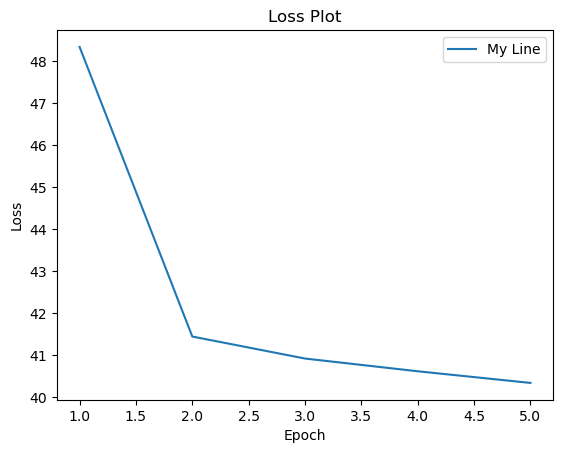

In [77]:
x_values=[i[0] for i in loss_values_model1]
y_values=[i[1] for i in loss_values_model1]
with torch.no_grad():
    plt.plot(x_values, y_values, label='My Line')

    # Add labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Plot')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()

In [42]:
# Assuming simclr_encoder is your SimCLR encoder
simclr_encoder.eval()

# Lists to store representations and labels
all_representations = []
all_labels = []
top1_accuracy=0
top5_accuracy=0
# Iterate through the validation loader
with torch.no_grad():
    counter=0;
    for batch in val_loader:
        images, labels_tuple = batch
        images = images.to(device)
        labels = labels_tuple[0].to(device)

        # Forward pass through the SimCLR encoder
        representations = simclr_encoder(images)

        # Normalize the representations
        representations = F.normalize(representations, dim=1)
        all_representations.append(representations)
        all_labels.append(labels_tuple)
        top1, top5 = accuracy(representations, labels_tuple, topk=(1,3))
        top1_accuracy += top1[0]
        top5_accuracy += top5[0]
        #print(counter,top1[0],top5[0],top1_accuracy,top5_accuracy )
        counter+=1
    top1_accuracy_val =top1_accuracy/ (counter )
    top5_accuracy_val =top5_accuracy/ (counter )
    
    print(f"for batch {counter}\tTop1 Test accuracy: {top1_accuracy_val.item()}\tTop5 test acc: {top5_accuracy_val.item()}")


for batch 4	Top1 Test accuracy: 19.831729888916016	Top5 test acc: 49.39904022216797


In [60]:
pred_labels=[]
true_labels=[]
for i in range(len(all_representations)):
    for j in range(len(all_representations[i])):
        pred_labels.append(np.argmax(all_representations[i][j]).item())
        true_labels.append(all_labels[i][j].item())

              precision    recall  f1-score   support

           0       0.18      0.24      0.20        42
           1       0.20      0.07      0.11        41
           2       0.18      0.26      0.21        38
           3       0.14      0.10      0.12        40
           4       0.20      0.15      0.17        41
           5       0.25      0.36      0.30        42

    accuracy                           0.20       244
   macro avg       0.19      0.20      0.18       244
weighted avg       0.19      0.20      0.19       244

[[10  4  6  1 14  7]
 [ 4  3 14  8  4  8]
 [ 8  3 10  2  4 11]
 [ 5  3 14  4  2 12]
 [15  2  9  3  6  6]
 [14  0  3 10  0 15]]


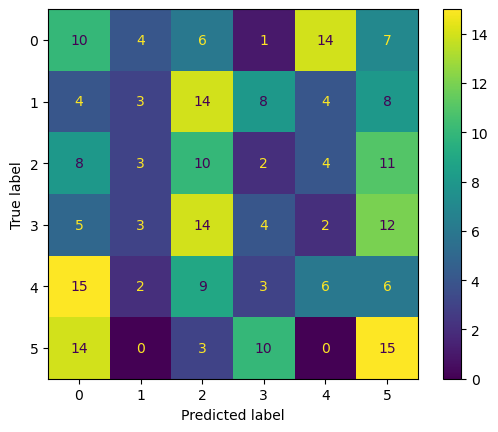

In [65]:
print(classification_report(true_labels, pred_labels))
cm = confusion_matrix(true_labels, pred_labels)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Model 2 Supervised Model using ResNet18

In [66]:
model = torchvision.models.resnet18(pretrained=False, num_classes=num_labels).to(device)

In [67]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [81]:
epochs = 5
loss_values_model2=[]
pred_labels=[]
true_labels=[]
for epoch in range(epochs):
    top1_train_accuracy = 0
    loss_epoch=0
    for counter, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).long()

        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        top1 = accuracy(logits, y_batch, topk=(1,))
        top1_train_accuracy += top1[0]
        loss_epoch+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_values_model2.append(loss_epoch)
    top1_train_accuracy /= (counter + 1)
    top1_accuracy = 0
    top5_accuracy = 0
    for counter, (x_batch, y_batch) in enumerate(val_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).long()

        logits = model(x_batch)
        pred_labels.append(logits)
        true_labels.append(y_batch)
        top1, top5 = accuracy(logits, y_batch, topk=(1,3))
        top1_accuracy += top1[0]
        top5_accuracy += top5[0]
  
    top1_accuracy /= (counter + 1)
    top5_accuracy /= (counter + 1)
    print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop3 test acc: {top5_accuracy.item()}")

Epoch 0	Top1 Train accuracy 97.72135162353516	Top1 Test accuracy: 69.35095977783203	Top3 test acc: 88.88220977783203
Epoch 1	Top1 Train accuracy 98.046875	Top1 Test accuracy: 71.00360107421875	Top3 test acc: 89.96394348144531
Epoch 2	Top1 Train accuracy 98.60025787353516	Top1 Test accuracy: 69.74158477783203	Top3 test acc: 90.26441955566406
Epoch 3	Top1 Train accuracy 99.0234375	Top1 Test accuracy: 71.60456848144531	Top3 test acc: 93.47956848144531
Epoch 4	Top1 Train accuracy 98.79557037353516	Top1 Test accuracy: 71.39422607421875	Top3 test acc: 91.52644348144531


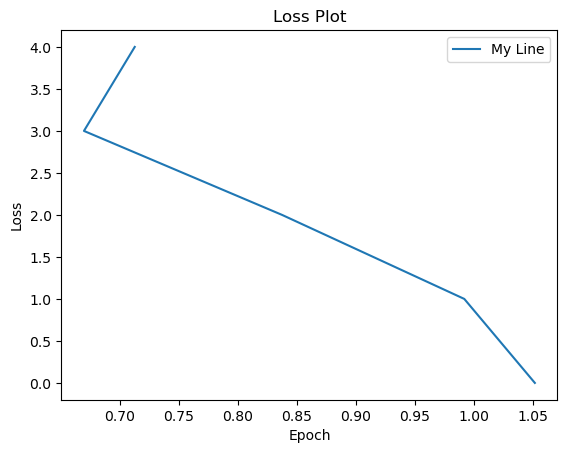

In [88]:
x_values=[i.item() for i in loss_values_model2]
y_values=[i for i in range(len(loss_values_model2))]
with torch.no_grad():
    plt.plot(x_values, y_values, label='My Line')

    # Add labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Plot')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()

In [97]:
all_representations=[]
all_labels=[]

for i in range(len(pred_labels)):
    for j in range(len(pred_labels[i])):
        all_representations.append(torch.argmax(pred_labels[i][j]).item())
        all_labels.append(true_labels[i][j].item())

In [101]:
print(classification_report(all_labels, all_representations))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       210
           1       0.70      0.64      0.67       205
           2       0.71      0.65      0.68       190
           3       0.58      0.64      0.61       200
           4       0.73      0.67      0.70       205
           5       0.80      0.94      0.87       210

    accuracy                           0.71      1220
   macro avg       0.70      0.70      0.70      1220
weighted avg       0.71      0.71      0.70      1220



In [104]:

cm = confusion_matrix(all_labels, all_representations)
print(cm)


[[142  13  16  18  14   7]
 [ 13 132  14  25   9  12]
 [  2   9 123  21  17  18]
 [ 34  15   6 128  12   5]
 [ 12   8  13  28 138   6]
 [  0  11   1   0   0 198]]


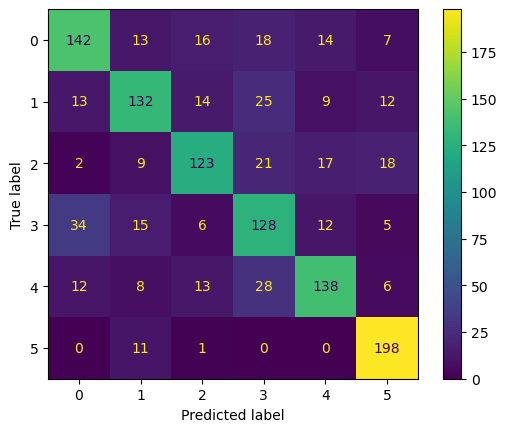

In [103]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()